In [109]:
import numpy as np
import librosa as lr

import torch
import auraloss

from kymatio_audio import scattering_audio_distance as sad

from IPython import display as ipd
plt.rcParams['figure.figsize'] = [6, 3]

In [110]:
i, sr = lr.load('audio/i.wav')
o, sr = lr.load('audio/o.wav')
i = i/np.max(np.abs(i))
o = o/np.max(np.abs(o))

def power_log(x):
    return int(2**(np.ceil(np.log2(x))))

l = np.min([i.shape[0], o.shape[0]])
l = power_log(l)
i = lr.util.fix_length(i, size=l)
o = lr.util.fix_length(o, size=l)

In [111]:
noise_levels = 10

i_n = []
o_n = []
for n in range(noise_levels):
    i_n.append(i+np.log10((n+1)/(noise_levels))/50*np.random.randn(i.shape[0]))
    o_n.append(o+np.log10((n+1)/(noise_levels))/50*np.random.randn(o.shape[0]))

i_series = np.hstack(i_n)
o_series = np.hstack(o_n)
ipd.Audio(i_series, rate=sr)

In [112]:

ipd.Audio(o_series, rate=sr)

In [149]:
s_n = i_n+o_n

aura_fn = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=[1024, 2048, 8192],
    hop_sizes=[256, 512, 2048],
    win_lengths=[1024, 2048, 8192],
    scale="mel",
    n_bins=128,
    sample_rate=sr,
    perceptual_weighting=True,
)

mss_distances = np.zeros((len(s_n), len(s_n)))
for s_ii, s_i in enumerate(s_n):
    for s_jj, s_j in enumerate(s_n): 
        if s_jj>s_ii:
            sit = torch.unsqueeze(torch.unsqueeze(torch.tensor(s_i, dtype=torch.float32), 0), 0)
            sjt = torch.unsqueeze(torch.unsqueeze(torch.tensor(s_j, dtype=torch.float32), 0), 0)
            mss_distances[s_ii, s_jj] = aura_fn(sit, sjt).numpy()
            mss_distances[s_jj, s_ii] = mss_distances[s_ii, s_jj]


0.39964723587036133
0.5792140960693359
0.7575376033782959
0.9506966471672058
1.1316792964935303
1.3508151769638062
1.6069426536560059
1.9829021692276
3.854078531265259
1.4829034805297852
1.6281250715255737
1.8058496713638306
1.9878679513931274
2.19598126411438
2.383262872695923
2.6143856048583984
2.9236690998077393
3.3329837322235107
5.189247131347656
0.3470064103603363
0.49996218085289
0.6751969456672668
0.8514857292175293
1.0679244995117188
1.3234307765960693
1.6983275413513184
3.5694754123687744
1.5976800918579102
1.5418792963027954
1.6381645202636719
1.7932381629943848
1.9897810220718384
2.1726672649383545
2.401691198348999
2.7104148864746094
3.119549036026001
4.975771427154541
0.31606075167655945
0.46103620529174805
0.628695011138916
0.8374606966972351
1.0902997255325317
1.4645100831985474
3.3357744216918945
1.7766857147216797
1.617853045463562
1.5797942876815796
1.6629842519760132
1.8329548835754395
2.0050692558288574
2.2295053005218506
2.534912109375
2.9437501430511475
4.7999138

In [114]:
scattering_distances = sad.scattering_audio_distance(s_n, sr)

Max num samples 16384
Max duration 0.7430385487528345 seconds.
Time support: 0.7430385487528345 seconds.


In [154]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

def plot_dist(distances, dist_type):
    emb = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, metric='precomputed').fit_transform(distances)
    emb = Isomap(n_components=2, metric='precomputed').fit_transform(distances)
    h1 = plt.scatter(emb[:10, 0], emb[:10, 1], sizes=(np.arange(10)+1)*8, label='i')
    plt.plot(emb[:10, 0], emb[:10, 1], linewidth=.3)
    h2 = plt.scatter(emb[10:, 0], emb[10:, 1], sizes=(np.arange(10)+1)*8, label='o')
    plt.plot(emb[10:, 0], emb[10:, 1], linewidth=.3)
    plt.legend(handles=[h1, h2])
    plt.title(dist_type)
    plt.show()

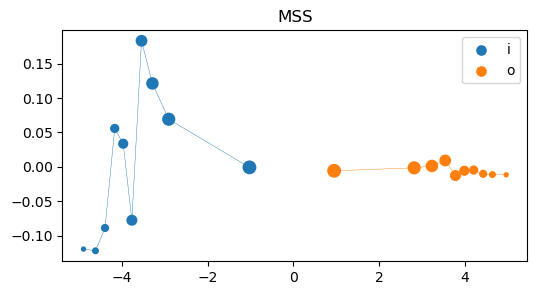

In [155]:
plot_dist(mss_distances, 'MSS')

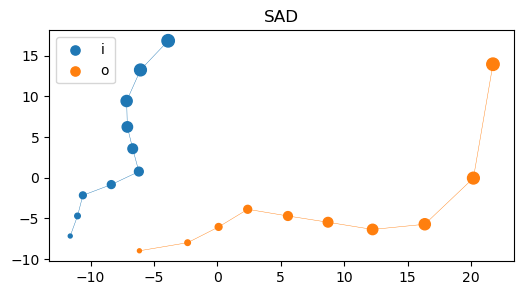

In [156]:

plot_dist(scattering_distances, 'SAD')